# Assignment 6: Feature selection and regularization

# Total: /100

## Instructions

* Complete the assignment

* Once the notebook is complete, **restart** your kernel and **rerun** your cells

* Submit this notebook to owl by the deadline

* You may use any python library functions you wish to complete the assignment.

In [1]:
# You may need these
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import sklearn.linear_model as skl
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RepeatedKFold, ShuffleSplit, LeaveOneOut
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
from IPython.display import display

seed = 2023
np.random.seed(seed)

## Question 1: /20 pts


Customer Lifetime Value (CLV) is the total income a business can expect from a customer over the entire period of their relationship. It’s an important metric as it costs less to keep existing customers than it does to acquire new ones, so increasing the value of your existing customers is a great way to drive growth. We want to predict CLV for an auto insurance company.

1. Read in the `Vehicle_Insurance.csv` dataset and display the last 5 rows.
2. Conduct the required data preparation.

### 1.1 Read the dataset and display the last 5 rows

In [ ]:
Data=pd.read_csv("Vehicle_Insurance.csv")
Data.tail()

# 1 pt

,clv,Coverage,Gender,Income,Marital.Status,Monthly.Premium.Auto,Number.of.Open.Complaints,Number.of.Policies,Renew.Offer.Type,Total.Claim.Amount,Vehicle.Class
8625,4100.398533,Premium,F,47761,Single,104,0,1,Offer1,541.282007,Four-Door Car
8626,3096.511217,Extended,F,21604,Divorced,79,0,1,Offer1,379.200000,Four-Door Car
8627,8163.890428,Extended,M,0,Single,85,3,2,Offer1,790.784983,Four-Door Car
8628,7524.442436,Extended,M,21941,Married,96,0,3,Offer3,691.200000,Four-Door Car
8629,2611.836866,Extended,M,0,Single,77,0,1,Offer4,369.600000,Two-Door Car


### 1.2 Keep only the rows with $2200 \leq$ "clv" $\leq 16000$ from the dataset. What's the shape of the dataframe now?

In [ ]:
Data=Data[(Data.clv>=2200)&(Data.clv<=16000)]

Data.shape

# 3 pts

(8212, 11)

### 1.3 Using `preprocessing.OneHotEncoder()`, convert all categorical features. Make sure not to add collinear features during the encoding process. Then, display the first 3 rows.

In [ ]:
ohe = preprocessing.OneHotEncoder(drop='first')
dataOHE = Data.copy()

categorical_cols = Data.select_dtypes(include='object').columns

for col in categorical_cols:
    n = dataOHE[col].nunique()

    #reshape the 1-D array to 2-D as fit_transform expects 2-D and finally fit the object 
    dummy = ohe.fit_transform(dataOHE[col].values.reshape(-1,1)).toarray()

    # To add this back into the original dataframe 
    dfOneHot = pd.DataFrame(dummy, columns = [col+str(int(i)) for i in range(n-1)]) 
    dataOHE = pd.concat([dataOHE.reset_index(drop=True), dfOneHot.reset_index(drop=True)], axis=1)

    #droping the cwork_rate_att column 
    dataOHE = dataOHE.drop([col], axis=1)

dataOHE.head(3)

# 6 pts

,clv,Income,Monthly.Premium.Auto,Number.of.Open.Complaints,Number.of.Policies,Total.Claim.Amount,Coverage0,Coverage1,Gender0,Marital.Status0,Marital.Status1,Renew.Offer.Type0,Renew.Offer.Type1,Renew.Offer.Type2,Vehicle.Class0,Vehicle.Class1,Vehicle.Class2,Vehicle.Class3,Vehicle.Class4
0,2763.519279,56274,69,0,1,384.811147,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,6979.535903,0,94,0,8,1131.464935,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12887.431650,48767,108,0,2,566.472247,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### 1.4 Use `pandas.DataFrame.apply` to apply square root transformation to "Total.Claim.Amount" and log to the target variable. And then, create your `X` and `y`.  (No training/test splitting yet) 

In [ ]:
dataOHE['Total.Claim.Amount'] = dataOHE['Total.Claim.Amount'].apply(np.sqrt)
dataOHE['clv'] = dataOHE['clv'].apply(np.log)

y = dataOHE['clv']
X= dataOHE.drop('clv', axis='columns')

# 3 pts

### 1.5 Build a new design matrix by applying polynomial expansion on the `X` from Question 1.4.

In [ ]:
# Specify degree=2 and do NOT include the column with power 0 (i.e., column with all elements being 1)
 
poly = sk.preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
poly_X = poly.fit_transform(X)

# 3 pts

### 1.6 Standardize your design matrix (from Question 1.5) with `StandardScaler()`, and store the result into a Pandas dataFrame.

In [ ]:
scalar = StandardScaler()
scalar.fit(poly_X) 
scaled_X = scalar.transform(poly_X) 

# 1 pt

In [ ]:
XDF = pd.DataFrame(scaled_X)
XDF.head()

# 1 pt

,0,1,2,3,4,5,6,7,8,9,...,179,180,181,182,183,184,185,186,187,188
0,0.603329,-0.712548,-0.420359,-0.830497,0.030067,-0.650746,-0.309768,-0.985733,0.842264,-0.603799,...,-0.118649,0.0,0.0,0.0,-0.486758,0.0,0.0,-0.230121,0.0,1.934254
1,-1.250653,0.095096,-0.420359,1.994204,2.104114,1.536698,-0.309768,-0.985733,-1.187276,1.656181,...,-0.118649,0.0,0.0,0.0,-0.486758,0.0,0.0,-0.230121,0.0,-0.516995
2,0.356006,0.547376,-0.420359,-0.426968,0.649009,-0.650746,3.228222,-0.985733,0.842264,-0.603799,...,-0.118649,0.0,0.0,0.0,-0.486758,0.0,0.0,-0.230121,0.0,1.934254
3,-1.250653,0.482765,-0.420359,1.590676,0.533399,-0.650746,-0.309768,1.014474,0.842264,-0.603799,...,-0.118649,0.0,0.0,0.0,2.054409,0.0,0.0,-0.230121,0.0,-0.516995
4,0.193551,-0.583325,-0.420359,-0.830497,-1.133194,-0.650746,-0.309768,1.014474,-1.187276,1.656181,...,-0.118649,0.0,0.0,0.0,-0.486758,0.0,0.0,-0.230121,0.0,-0.516995


### 1.7 What is the shape of the resultant DataFrame obtained from question 1.6?

In [ ]:
XDF.shape

# 2 pts

(8212, 189)

## Question 2: /7 pts

Split the data into training and test sets. Hold out 30% of observations as the test set.  Pass `random_state=seed` to `train_test_split` to ensure you get the same sets per run. The design matrix to pass in to the splitter function is the dataframe whcih you got in Question 1.6. As for the target, you have created it in Question 1.4.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(XDF , y, test_size=0.3, random_state=seed)

print(X_train.shape)

round(y_train.mean(),2)

# 5 pts

(5748, 189)


8.62

How many observations in your traning data set? What is the average value of the target variable in the traning data set (keep 2 decimal place)?

**YOUR ANSWER HERE:** [2pts]

5748 observations in the traning data set. And the average value of the target variable in the traning data set is 8.62.

## Question 3: /23 pts

### 3.1 Create a SciKit Learn `Ridge` regression object. Using this object, run a ridge regression analysis of the target variable against all the transformed predictor variables using your training data. Include the arguement `alpha=4.0`. In addition, the ridge regression should be fitted with the intercept.

In [ ]:
ridge = skl.Ridge(alpha=4.0, fit_intercept=True)

RL =ridge.fit(X_train,y_train)

# 5 pts

### 3.2 Vary the ridge coeficient `alpha` according to the hint. Use `cross_val_score()` to select the best `alpha` based on 'mean_squared_error'. Include the argument `cv=5`. Report the `alpha` that yields the smallest mean_squared_error.   

In [ ]:
lam = np.exp(np.linspace(-4,1,10))

mse = np.zeros(10)
for i in range(lam.size):
    cv_scores = cross_val_score(skl.Ridge(alpha=lam[i]), X_train, y_train, cv=5, scoring = 'neg_mean_squared_error')
    mse[i]=-cv_scores.mean()

# 6 pts

In [ ]:
lam[np.argmin(mse)]
# 2 pts

1.559623497606781

### 3.3 Re-fit the ridge regression with `alpha` being the value obtained in the previous question. `Print` the first 3 parameters of your model.

In [ ]:
ridge = skl.Ridge(alpha=lam[np.argmin(mse)], fit_intercept=True)

RL =ridge.fit(X_train,y_train)

print(f'The first 3 parameters of the model are : {RL.coef_[0:3]}')

# 3 pts

The first 3 parameters of the model are : [0.02839762 0.33081133 0.02778567]


### 3.4 Fit the linear regression without any penalty, and the regression should be fitted with the intercept. `Print` the first 3 parameters of your model.

In [ ]:
Reg = skl.LinearRegression(fit_intercept=True)

RGL = Reg.fit(X_train,y_train)

print(f'The first 3 parameters of the model are : {RGL.coef_[0:3]}')

# 3 pts

The first 3 parameters of the model are : [0.01836491 0.22405672 0.0293542 ]


Comparing the parameters that you obtain in questions 3.3 and 3.4, what do you find?

**YOUR ANSWER HERE:** [2pts]

The Ridge has resulted in larger parameters except for the last one.

### 3.5 Use your trained model from Question 3.4 to predict over the test set and `print` the first 5 prediction values.

In [ ]:
yp = RGL.predict(X_test)

print(yp[0:5])

# 2 pts

[9.23937373 8.30926286 8.89959489 8.09344255 8.43944697]


## Question 4: /25 pts

### 4.1 Consider to fit a Lasso regression to the train dataset. Use `lasso_path()` to show the full path of the first 20 coefficients of the Lasso regression. Include the arguement `eps=8e-3` and `n_alphas=50`.

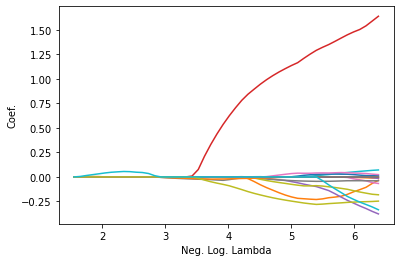

In [ ]:
# Draw a plot to show the path. Legend is not required in the plot. 
lambda_lasso, coefs_lasso, _ = skl.lasso_path(X_train,y_train, eps=8e-3, n_alphas=50, alphas= None)

neg_log_lambda = -np.log(lambda_lasso)
for i in range(20):
    l1 = plt.plot(neg_log_lambda, coefs_lasso[i,])

plt.xlabel('Neg. Log. Lambda')
plt.ylabel('Coef.')

plt.show()

# 7 pts

Describe the trend that shows in your figure.

**YOUR ANSWER HERE:** [3pts] 

On the x-axis, a larger value corresponds to a smaller tuning parameter associated with the regularization (i.e. smaller strength of the penalization). Larger values on the x-axis yield more non-zero coefficients.*

### 4.2 Use the Scikit Learn's cross-validated LASSO to automatically search for the best tuning parameter of the LASSO regression on the training set with intercept. Include arguments `eps=8e-3`, `n_alphas=30`, `tol=0.001`, `cv=5`, and `random_state=seed`. Report the best tuning parameter and the number of the non-zero coefficients in the model.

In [ ]:
LASS = skl.LassoCV(eps=8e-3,
                   n_alphas=30,
                   alphas=None,
                   fit_intercept=True,
                   tol=0.001,
                   cv=5, 
                   n_jobs=4,
                   random_state=seed)

# 5 pts

In [ ]:
LASS.fit(X_train,y_train)

# 1 pt

LassoCV(cv=5, eps=0.008, n_alphas=30, n_jobs=4, random_state=2023, tol=0.001)

In [ ]:
# Print best tuning parameter
print('Best fit: alpha=%.3f' % LASS.alpha_)

# 1 pt

Best fit: alpha=0.002


In [ ]:
LASS.coef_.size-sum(LASS.coef_==0)

# 1 pt

92

### 4.3 Use the Scikit Learn's cross-validated ElasticNet to automatically search for the best tuning parameters of the Elasticnet regression with intercept on the training data set. Include the same argument as question 4.2 as well as `l1_ratio=[.7, .9, .95, .99,1]`. Report the best tuning parameters.

In [ ]:
Elastic = skl.ElasticNetCV(eps=8e-3,
                           n_alphas=30,
                           alphas=None,
                           fit_intercept=True,
                           l1_ratio=[ .7, .9, .95, .99,1],
                           tol=0.001,
                           cv=5,
                           n_jobs=4,
                           random_state=seed)

Elastic.fit(X_train,y_train)

# 3 pts

ElasticNetCV(cv=5, eps=0.008, l1_ratio=[0.7, 0.9, 0.95, 0.99, 1], n_alphas=30,
             n_jobs=4, random_state=2023, tol=0.001)

In [ ]:
# Print best coefficients
print('Best fit: alpha=%.3f, l1_ratio=%.3f' % (Elastic.alpha_, Elastic.l1_ratio_))

# 1 pt

Best fit: alpha=0.002, l1_ratio=1.000


From the obtained tuning parameters, is the Elasticnet regression model equivalent to the Lasso regression? Briefly describe the reason. 

**YOUR ANSWER HERE:** [3pts]

Yes. Since the l1_ratio=1, the Elasticnet regression model degenerates to the Lasso regression.

## Question 5: /16 pts

### 5.1 Start from the regression model in question 3.4, use `SequentialFeatureSelector()` to conduct the forward selection for the features of the regression model. Include the argument `n_features_to_select=20`. Report the indices of the selected features. 

FYI: Running this using 8 physical cores took about 1 minute for me.

In [ ]:
sfs = SequentialFeatureSelector(Reg, n_features_to_select=20, n_jobs=8)

#4pts

In [ ]:
sfs.fit(X_train,y_train)

#2pts

SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select=20,
                          n_jobs=8)

In [ ]:
SL_F=sfs.get_support()
np.where(SL_F==True)[0]

#4pts

array([  1,   3,  12,  18,  19,  20,  28,  36,  38,  55,  59,  69,  75,
       104, 117, 118, 119, 126, 131, 143])

What do you need to change about the argument in your model if you want to conduct a backward selection?

**YOUR ANSWER HERE:** [2pts] 

We need to pass in the argument `direction='backward'` to the model.

### 5.2 Re-fit the regular linear regression based on the traning set by using the selected features from the question 5.1. Report the first 3 parameters of your model as indicated with the print function.

In [ ]:
X_train1 =sfs.transform(X_train)
X_test1  =sfs.transform(X_test)

#2pts

In [ ]:
RGL1= Reg.fit(X_train1,y_train)
print(f'The first 3 parameters of the model are : {RGL1.coef_[0:3]}')

#2pts

The first 3 parameters of the model are : [ 0.48181157  1.07122953 -0.0122778 ]


## Question 6: /9 pts

### 6.1 Make predictions on the test set using your models in questions 3.3, 4.2, 4.3, and 5.2, respectively. Together with the predicted values obtained in question 3.5, report the first 5 rows of predicted values obtained from different models in a single DataFrame.

In [ ]:
yp1  = RGL1.predict(X_test1)
yp_r = RL.predict(X_test)
yp_l = LASS.predict(X_test)
yp_E = Elastic.predict(X_test)
pd.DataFrame({'Linear Reg':yp, 'Forward selection': yp1, 'Ridge': yp_r, 'LASSO': yp_l, 'Elasticnet': yp_E}).head()

#3pts

,Linear Reg,Forward selection,Ridge,LASSO,Elasticnet
0,9.239557,9.197035,9.244224,9.142903,9.142903
1,8.319282,8.300987,8.317220,8.303288,8.303288
2,8.895637,8.910826,8.894495,8.859596,8.859596
3,8.082100,8.025311,8.083858,8.085032,8.085032
4,8.446955,8.445480,8.433497,8.416404,8.416404


### 6.2 Use `mean_squared_error()` to assess the performance of different models based on all the predicted values mentioned in Question 6.1.  

In [ ]:
MSE   = metrics.mean_squared_error(y_test,yp)
MSE1  = metrics.mean_squared_error(y_test,yp1)
MSE_r = metrics.mean_squared_error(y_test,yp_r)
MSE_l = metrics.mean_squared_error(y_test,yp_l)
MSE_E = metrics.mean_squared_error(y_test,yp_E)

MSE_all=pd.Series([MSE, MSE1, MSE_r,MSE_l, MSE_E])
MSE_all.argmin()

#4pts

3

Which model yields the smallest mean squared error on the test dataset?

**YOUR ANSWER HERE:** [2pts]

The LASSO regression leads to the smallest mean squared error on the test dataset.